# Przykładowy scenariusz

Pierwsza iteracja. Może być nawet z wykorzystaniem prostego mechanizmu.

## Opis domeny

Scenariusze biznesowe.

## Problemu / Drivetrain approach

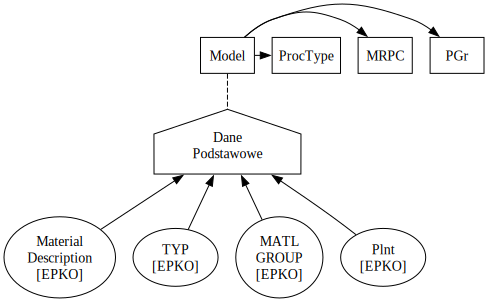

In [ ]:
from graphviz import Digraph, Source

src = Source(
    """digraph {         
    M [shape=box, label="Model"]
    
    {
    
    PRED_1 [shape=box, label="PGr"];
    PRED_2 [shape=box, label="MRPC"];
    PRED_3 [shape=box, label="ProcType"];
    
    {rank = "same"; M -> PRED_1; M -> PRED_2; M -> PRED_3}
    }

    TRAIN_DATA [shape="house", label="Dane\nPodstawowe"]
    
    
    {M -> TRAIN_DATA  [style="dashed",arrowhead="none" ]}
    
    TRAIN_DATA_ATR1[label="Material\nDescription\n[EPKO]"]
    TRAIN_DATA_ATR2[label="TYP\n[EPKO]"]
    TRAIN_DATA_ATR3[label="MATL\nGROUP\n[EPKO]"]
    TRAIN_DATA_ATR4[label="Plnt\n[EPKO]"]
    
    {TRAIN_DATA -> TRAIN_DATA_ATR1 [dir=back]}
    {TRAIN_DATA -> TRAIN_DATA_ATR2 [dir=back];}
    {TRAIN_DATA -> TRAIN_DATA_ATR3 [dir=back];}
    {TRAIN_DATA -> TRAIN_DATA_ATR4 [dir=back];}
    
    }"""
)

# src.render("slides/img/scenario", format="svg", view=False)

src

# FOREX game

Naszym celem jest przewidzenie pary EUR do Dolara w oparciu o największe giełdy (USD - DAW Jones i NASDAQ, EURO - DAX and CAC 40). Zobaczmy różne podejścia od najprostszych (regresja) po zastosowanie modeli machine learning.

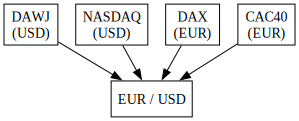

In [ ]:
src = Source(
    """digraph {         
    DAWJ [shape=box, label="DAWJ\n(USD)"];
    NASDAQ [shape=box, label="NASDAQ\n(USD)"];
    
    DAX [shape=box, label="DAX\n(EUR)"];
    CAC40 [shape=box, label="CAC40\n(EUR)"];
    
    GOAL [shape=box, label="EUR / USD"];
    
    DAWJ -> GOAL; NASDAQ -> GOAL; DAX -> GOAL; CAC40 -> GOAL
    
    }"""
)

src

## Drive Train

1. Cel: zwiększenie zwrotów inwestycyjnych o X;

2. Co będziemy robić: trafne przewidzenie pary walut EUR/USD;

3. Dane:

   - dane historyczne EUR/USD,
   - performance giełd w Europie i USA.

4. Model do przewidzenia z wyprzedzeniem pary walut.

### Praca z danymi

Pierwsza iteracja, możemy szybko przejść do modelu, a potem wrócić do sprawdzenia danych wejściowych dokładniej, aby je lepiej przygotować.

Zalezy od scenariusza, pamiętaj, aby się niezakopać tutaj.

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# Dow Jones Industry - DJI
df_all_dji = pd.read_csv(
    "data/^DJI(Dow Jones industry).csv",
    delimiter=",",
    low_memory=False,
    parse_dates=["Date"],
)

In [ ]:
# IXIC NASDAQ
df_all_ixic = pd.read_csv(
    "data/^IXIC(NASDAQ).csv", delimiter=",", low_memory=False, parse_dates=["Date"]
)

In [ ]:
# DAX - Germany
df_all_dax = pd.read_csv(
    "data/DAX(Germany).csv", delimiter=",", low_memory=False, parse_dates=["Date"]
)

In [ ]:
# CEC - France
df_all_cec = pd.read_csv(
    "data/^FCHI(CAC40).csv", delimiter=",", low_memory=False, parse_dates=["Date"]
)

In [ ]:
# what we want to predict EURO/USD
df_all_eurusd = pd.read_csv(
    "data/EURUSD=X.csv", delimiter=",", low_memory=False, parse_dates=["Date"]
)

In [ ]:
df_all_ixic.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
12869,2022-02-14,13768.969727,13921.709961,13664.759766,13790.919922,13790.919922,4301470000
12870,2022-02-15,13997.179688,14142.490234,13976.290039,14139.759766,14139.759766,4393050000
12871,2022-02-16,14038.919922,14163.730469,13931.990234,14124.089844,14124.089844,4224060000
12872,2022-02-17,14004.190430,14020.820313,13704.700195,13716.719727,13716.719727,4259890000
12873,2022-02-18,13735.400391,13762.400391,13465.559570,13548.070313,13548.070313,4475010000


In [ ]:
df_all_cec.describe()

,Date,Open,High,Low,Close,Adj Close,Volume
count,8260,8113.000000,8113.000000,8113.000000,8113.000000,8113.000000,8.113000e+03
mean,2006-01-27 16:54:06.101694976,3935.299732,3962.732919,3905.013231,3934.832260,3934.832260,6.383140e+07
min,1990-03-01 00:00:00,1438.000000,1459.000000,1425.000000,1441.000000,1441.000000,0.000000e+00
25%,1998-01-28 18:00:00,2930.399902,2954.399902,2892.899902,2929.100098,2929.100098,0.000000e+00
50%,2005-12-28 12:00:00,4015.000000,4037.899902,3983.129883,4013.969971,4013.969971,6.477270e+07
75%,2014-01-28 06:00:00,4994.180176,5024.509766,4958.709961,4994.700195,4994.700195,1.130928e+08
max,2022-02-18 00:00:00,7320.479980,7384.859863,7313.529785,7376.370117,7376.370117,5.312476e+08
std,NaN,1384.037954,1391.060494,1376.388029,1383.758142,1383.758142,6.926234e+07


<Axes: xlabel='Date', ylabel='Close'>

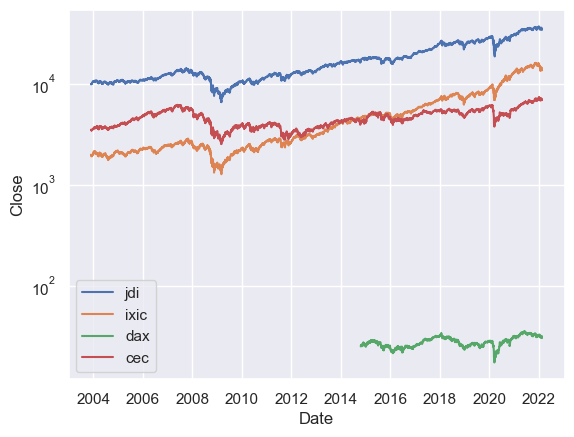

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

inital_plot_cut = pd.to_datetime(min(df_all_eurusd["Date"]), format="%Y-%m-%d")

sns.set_theme(style="darkgrid")

# due to the difference of the Close values
# let's change to the log scale on the Y axis
f, ax = plt.subplots()
ax.set(yscale="log")

# Plot the responses for different events and regions
sns.lineplot(
    x="Date",
    y="Close",
    data=df_all_dji[df_all_dji["Date"] > inital_plot_cut],
    label="jdi",
)
sns.lineplot(
    x="Date",
    y="Close",
    data=df_all_ixic[df_all_ixic["Date"] > inital_plot_cut],
    label="ixic",
)
sns.lineplot(
    x="Date",
    y="Close",
    data=df_all_dax[df_all_dax["Date"] > inital_plot_cut],
    label="dax",
)
sns.lineplot(
    x="Date",
    y="Close",
    data=df_all_cec[df_all_cec["Date"] > inital_plot_cut],
    label="cec",
)

<Axes: xlabel='Date', ylabel='Close'>

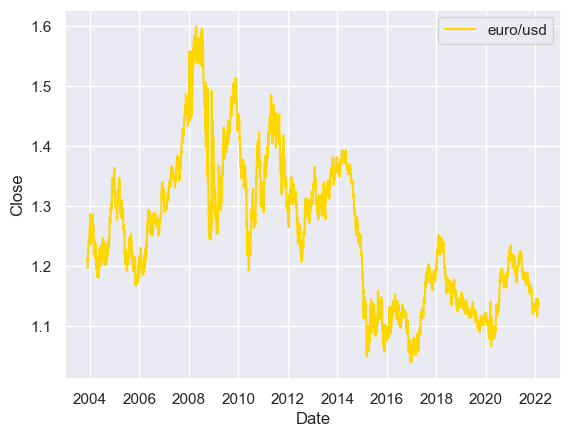

In [ ]:
import seaborn as sns

sns.set_theme(style="darkgrid")

df_all_eurusd

sns.lineplot(x="Date", y="Close", data=df_all_eurusd, label="euro/usd", color="gold")

### Przygotowanie jednego obiektu z danymi

In [ ]:
cut_point = pd.to_datetime("2014-10-22", format="%Y-%m-%d")

In [ ]:
df_dji = df_all_dji[(df_all_dji["Date"] > cut_point)]
df_ixic = df_all_ixic[(df_all_ixic["Date"] > cut_point)]
df_dax = df_all_dax[(df_all_dax["Date"] > cut_point)]
df_cec = df_all_cec[(df_all_cec["Date"] > cut_point)]
df_eurusd = df_all_eurusd[(df_all_eurusd["Date"] > cut_point)]

#### Join DAWJ i NASDAQ

In [ ]:
left = df_dji.set_index(["Date"])
right = df_ixic.set_index(["Date"])

df_stocks_usd = left.join(right, lsuffix="_DJI", rsuffix="_NASDAQ")
df_stocks_usd.tail()

,Open_DJI,High_DJI,Low_DJI,Close_DJI,Adj Close_DJI,Volume_DJI,Open_NASDAQ,High_NASDAQ,Low_NASDAQ,Close_NASDAQ,Adj Close_NASDAQ,Volume_NASDAQ
Date,,,,,,,,,,,,
2022-02-14,34694.500000,34744.558594,34304.281250,34566.171875,34566.171875,370320000,13768.969727,13921.709961,13664.759766,13790.919922,13790.919922,4301470000
2022-02-15,34686.191406,35047.789063,34686.191406,34988.839844,34988.839844,305670000,13997.179688,14142.490234,13976.290039,14139.759766,14139.759766,4393050000
2022-02-16,34951.828125,35042.089844,34642.640625,34934.269531,34934.269531,294410000,14038.919922,14163.730469,13931.990234,14124.089844,14124.089844,4224060000
2022-02-17,34858.468750,34858.468750,34246.230469,34312.031250,34312.031250,348720000,14004.190430,14020.820313,13704.700195,13716.719727,13716.719727,4259890000
2022-02-18,34310.449219,34423.578125,33976.179688,34079.179688,34079.179688,414080000,13735.400391,13762.400391,13465.559570,13548.070313,13548.070313,4475010000


#### Join DAX i CEC

In [ ]:
left = df_all_dax.set_index(["Date"])
right = df_all_cec.set_index(["Date"])

df_stocks_eur = left.join(right, lsuffix="_DAX", rsuffix="_CEC")
df_stocks_eur.tail()

,Open_DAX,High_DAX,Low_DAX,Close_DAX,Adj Close_DAX,Volume_DAX,Open_CEC,High_CEC,Low_CEC,Close_CEC,Adj Close_CEC,Volume_CEC
Date,,,,,,,,,,,,
2022-02-14,30.650000,30.650000,30.264000,30.459999,30.459999,18900,6868.069824,6875.310059,6757.330078,6852.200195,6852.200195,117972900.0
2022-02-15,31.260000,31.389999,31.110001,31.340000,31.340000,5500,6830.740234,6983.140137,6823.450195,6979.970215,6979.970215,92474100.0
2022-02-16,31.290001,31.629999,31.120001,31.510000,31.510000,4900,7009.689941,7031.930176,6931.089844,6964.979980,6964.979980,74789000.0
2022-02-17,31.209999,31.209999,30.799999,30.872000,30.872000,3500,6999.129883,7017.069824,6905.689941,6946.819824,6946.819824,90183200.0
2022-02-18,30.709999,30.709999,30.400000,30.559999,30.559999,10800,6951.830078,6995.620117,6895.089844,6929.629883,6929.629883,87348900.0


#### Stocks

In [ ]:
# now, we will join all stack data
df_stocks = df_stocks_eur.join(df_stocks_usd)
df_stocks.tail()

,Open_DAX,High_DAX,Low_DAX,Close_DAX,Adj Close_DAX,Volume_DAX,Open_CEC,High_CEC,Low_CEC,Close_CEC,...,Low_DJI,Close_DJI,Adj Close_DJI,Volume_DJI,Open_NASDAQ,High_NASDAQ,Low_NASDAQ,Close_NASDAQ,Adj Close_NASDAQ,Volume_NASDAQ
Date,,,,,,,,,,,,,,,,,,,,,
2022-02-14,30.650000,30.650000,30.264000,30.459999,30.459999,18900,6868.069824,6875.310059,6757.330078,6852.200195,...,34304.281250,34566.171875,34566.171875,370320000,13768.969727,13921.709961,13664.759766,13790.919922,13790.919922,4301470000
2022-02-15,31.260000,31.389999,31.110001,31.340000,31.340000,5500,6830.740234,6983.140137,6823.450195,6979.970215,...,34686.191406,34988.839844,34988.839844,305670000,13997.179688,14142.490234,13976.290039,14139.759766,14139.759766,4393050000
2022-02-16,31.290001,31.629999,31.120001,31.510000,31.510000,4900,7009.689941,7031.930176,6931.089844,6964.979980,...,34642.640625,34934.269531,34934.269531,294410000,14038.919922,14163.730469,13931.990234,14124.089844,14124.089844,4224060000
2022-02-17,31.209999,31.209999,30.799999,30.872000,30.872000,3500,6999.129883,7017.069824,6905.689941,6946.819824,...,34246.230469,34312.031250,34312.031250,348720000,14004.190430,14020.820313,13704.700195,13716.719727,13716.719727,4259890000
2022-02-18,30.709999,30.709999,30.400000,30.559999,30.559999,10800,6951.830078,6995.620117,6895.089844,6929.629883,...,33976.179688,34079.179688,34079.179688,414080000,13735.400391,13762.400391,13465.559570,13548.070313,13548.070313,4475010000


### Wszystko razem

In [ ]:
# now, let's get the values
# we want to predict EURUSD
right = df_eurusd.set_index(["Date"])
df_complete = df_stocks.join(right)

df_complete.tail()

,Open_DAX,High_DAX,Low_DAX,Close_DAX,Adj Close_DAX,Volume_DAX,Open_CEC,High_CEC,Low_CEC,Close_CEC,...,Low_NASDAQ,Close_NASDAQ,Adj Close_NASDAQ,Volume_NASDAQ,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,,,,,,,,,,,,,,,
2022-02-14,30.650000,30.650000,30.264000,30.459999,30.459999,18900,6868.069824,6875.310059,6757.330078,6852.200195,...,13664.759766,13790.919922,13790.919922,4301470000,1.136583,1.136893,1.129280,1.136506,1.136506,0.0
2022-02-15,31.260000,31.389999,31.110001,31.340000,31.340000,5500,6830.740234,6983.140137,6823.450195,6979.970215,...,13976.290039,14139.759766,14139.759766,4393050000,1.130608,1.136880,1.130582,1.130633,1.130633,0.0
2022-02-16,31.290001,31.629999,31.120001,31.510000,31.510000,4900,7009.689941,7031.930176,6931.089844,6964.979980,...,13931.990234,14124.089844,14124.089844,4224060000,1.135564,1.139315,1.134546,1.135680,1.135680,0.0
2022-02-17,31.209999,31.209999,30.799999,30.872000,30.872000,3500,6999.129883,7017.069824,6905.689941,6946.819824,...,13704.700195,13716.719727,13716.719727,4259890000,1.137333,1.138693,1.132759,1.137527,1.137527,0.0
2022-02-18,30.709999,30.709999,30.400000,30.559999,30.559999,10800,6951.830078,6995.620117,6895.089844,6929.629883,...,13465.559570,13548.070313,13548.070313,4475010000,1.136389,1.137669,1.131580,1.136648,1.136648,0.0


In [ ]:
df_complete.dtypes

Open_DAX            float64
High_DAX            float64
Low_DAX             float64
Close_DAX           float64
Adj Close_DAX       float64
Volume_DAX            int64
Open_CEC            float64
High_CEC            float64
Low_CEC             float64
Close_CEC           float64
Adj Close_CEC       float64
Volume_CEC          float64
Open_DJI            float64
High_DJI            float64
Low_DJI             float64
Close_DJI           float64
Adj Close_DJI       float64
Volume_DJI            int64
Open_NASDAQ         float64
High_NASDAQ         float64
Low_NASDAQ          float64
Close_NASDAQ        float64
Adj Close_NASDAQ    float64
Volume_NASDAQ         int64
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume              float64
dtype: object

In [ ]:
df_complete.shape

(1845, 30)

#### Warto zwizualizować dane

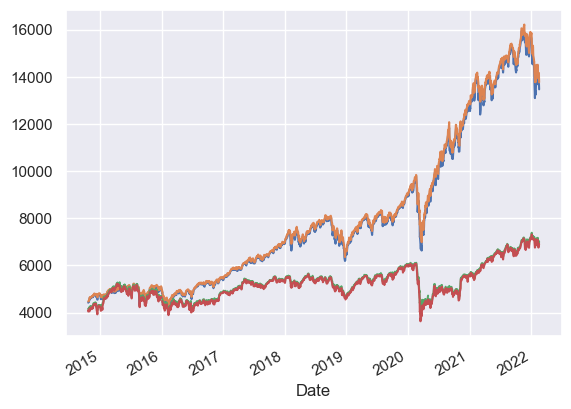

In [ ]:
# df_complete["High_DAX"].plot()
df_complete["Low_NASDAQ"].plot()
df_complete["High_NASDAQ"].plot()

df_complete["High_CEC"].plot()
df_complete["Low_CEC"].plot()

plt.show()

Jaki może być problem z danymi? Co może być problemem dla algorytmów?

#### Puste wartości

In [ ]:
df_complete[df_complete["Close"].notna()].shape

(1842, 30)

In [ ]:
df_complete[df_complete["Close"].isna()].shape

(3, 30)

## Regresja liniowa

In [ ]:
variable = ["Close_DJI", "Close_NASDAQ", "Close_CEC", "Close_DAX"]
dep = ["Close"]

selected = variable + dep

In [ ]:
df = df_complete[selected].copy()
df.tail()

,Close_DJI,Close_NASDAQ,Close_CEC,Close_DAX,Close
Date,,,,,
2022-02-14,34566.171875,13790.919922,6852.200195,30.459999,1.136506
2022-02-15,34988.839844,14139.759766,6979.970215,31.340000,1.130633
2022-02-16,34934.269531,14124.089844,6964.979980,31.510000,1.135680
2022-02-17,34312.031250,13716.719727,6946.819824,30.872000,1.137527
2022-02-18,34079.179688,13548.070313,6929.629883,30.559999,1.136648


In [ ]:
df.shape

(1845, 5)

In [ ]:
df[df["Close"].isna()].shape

(3, 5)

In [ ]:
df[df.isna().any(axis=1)].shape

(20, 5)

In [ ]:
df[df.isna().any(axis=1)]

,Close_DJI,Close_NASDAQ,Close_CEC,Close_DAX,Close
Date,,,,,
2014-12-26,18053.710938,4806.859863,NaN,26.600000,1.221001
2015-04-06,17880.849609,4917.319824,NaN,28.900000,1.100134
2015-05-01,18024.060547,5005.390137,NaN,28.240000,1.121466
2015-12-31,17425.029297,5007.410156,NaN,24.889999,1.093398
2016-03-28,17535.390625,4766.790039,NaN,23.690001,1.115997
2017-04-17,20636.919922,5856.790039,NaN,26.771000,1.061053
2017-05-01,20913.460938,6091.600098,NaN,28.290001,1.090750
2017-07-11,21409.070313,6193.299805,5140.600098,28.961000,NaN
2017-11-16,23458.359375,6793.290039,5336.390137,31.290001,NaN


In [ ]:
dt = pd.to_datetime("2014-12-26", format="%Y-%m-%d")
df.loc[[dt]]

,Close_DJI,Close_NASDAQ,Close_CEC,Close_DAX,Close
Date,,,,,
2014-12-26,18053.710938,4806.859863,NaN,26.6,1.221001


In [ ]:
df.shape

(1845, 5)

Jako, że jest to pierwsza iteracja, wyrzućmy wiersze z pustymi wartościami.

In [ ]:
df = df.dropna(axis=0)

In [ ]:
df.shape

(1825, 5)

In [ ]:
df = df.sort_index()

In [ ]:
df.tail()

,Close_DJI,Close_NASDAQ,Close_CEC,Close_DAX,Close
Date,,,,,
2022-02-14,34566.171875,13790.919922,6852.200195,30.459999,1.136506
2022-02-15,34988.839844,14139.759766,6979.970215,31.340000,1.130633
2022-02-16,34934.269531,14124.089844,6964.979980,31.510000,1.135680
2022-02-17,34312.031250,13716.719727,6946.819824,30.872000,1.137527
2022-02-18,34079.179688,13548.070313,6929.629883,30.559999,1.136648


In [ ]:
df.head()

,Close_DJI,Close_NASDAQ,Close_CEC,Close_DAX,Close
Date,,,,,
2014-10-23,16677.900391,4452.790039,4157.680176,25.250000,1.264143
2014-10-24,16805.410156,4483.720215,4128.899902,25.190001,1.265406
2014-10-27,16817.939453,4485.930176,4096.740234,25.028000,1.267668
2014-10-28,17005.750000,4564.290039,4112.669922,25.510000,1.270148
2014-10-29,16974.310547,4549.229980,4110.640137,25.670000,1.273837


In [ ]:
train_valid_cut = pd.to_datetime("2020-11-22", format="%Y-%m-%d")

train = df[(df.index < train_valid_cut)]
valid = df[(df.index >= train_valid_cut)]

In [ ]:
x_train = train.drop("Close", axis=1)
y_train = train["Close"]

In [ ]:
x_valid = valid.drop("Close", axis=1)
y_valid = valid["Close"]

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline


model =  make_pipeline(LinearRegression())
model.fit(x_train, y_train)

Pipeline(steps=[('linearregression', LinearRegression())])

In [ ]:
preds = model.predict(x_valid)

# RMSE - Root Mean Square error
rmse = np.sqrt(np.mean(np.power((np.array(y_valid) - np.array(preds)), 2)))
print(rmse)

0.07065864448484244


<Axes: xlabel='Date', ylabel='Close'>

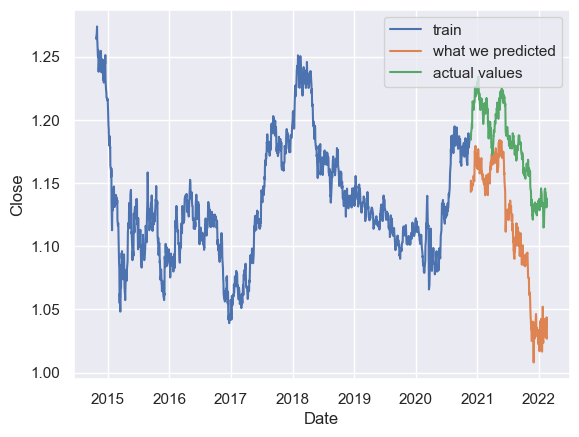

In [ ]:
valid_plot = valid.copy()

valid_plot["Prediction"] = preds

sns.set_theme(style="darkgrid")

sns.lineplot(x="Date", y="Close", data=train, label="train")
sns.lineplot(x="Date", y="Prediction", data=valid_plot, label="what we predicted")
sns.lineplot(x="Date", y="Close", data=valid_plot, label="actual values")

Twoje zadanie:

1. Odtwórz przygotowanie danych w notebooku 02_twoja_praca;
2. Uruchom regresję;
3. W drugiej iteracji, zmień dane, które wykorzystujemy do predykcji.

# Przykład 2 - Machine Learning

Pomysł na zmianę naszego algorytmu:

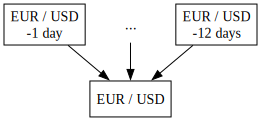

In [ ]:
src = Source(
    """digraph {         
    minus1 [shape=box, label="EUR / USD\n -1 day"];
    
    DAX [shape=box, label="...", color=white];
    minus2 [shape=box, label="EUR / USD\n -12 days"];
    
    GOAL [shape=box, label="EUR / USD"];
    
    minus1 -> GOAL; DAX -> GOAL; minus2 -> GOAL
    
    }"""
)

src

## Przygotowanie danych

In [ ]:
df_ml = df.copy()

In [ ]:
def lag_with_pct_change(in_df, windows):
    train_cols = []
    for window in reversed(windows):
        in_df["shift_pos_" + str(window)] = (
            in_df["Close"].shift(window).fillna(0).astype(np.float32)
        )
        train_cols.append("shift_pos_" + str(window))
    return in_df[len(windows) :], train_cols

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# see https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
currency_close_scaler = MinMaxScaler(feature_range=(-1, 1))

In [ ]:
# the first step is to transform the "Close" value into values in the range (-1, 1):
df_ml["Close"] = currency_close_scaler.fit_transform(
    df_ml["Close"].values.reshape(-1, 1)
).flatten()

In [ ]:
df_ml, train_cols = lag_with_pct_change(df_ml, range(1, 13))

#
df_ml["Close"] = df_ml["Close"].astype(np.float32)

In [ ]:
dep_col = ["Close"]
all_cols = train_cols + dep_col

In [ ]:
df_ml.tail(13)

,Close_DJI,Close_NASDAQ,Close_CEC,Close_DAX,Close,shift_pos_12,shift_pos_11,shift_pos_10,shift_pos_9,shift_pos_8,shift_pos_7,shift_pos_6,shift_pos_5,shift_pos_4,shift_pos_3,shift_pos_2,shift_pos_1
Date,,,,,,,,,,,,,,,,,
2022-02-02,35629.328125,14417.549805,7115.270020,31.650000,-0.247421,-0.091401,-0.131053,-0.199983,-0.188270,-0.213527,-0.189914,-0.204685,-0.221372,-0.273334,-0.355543,-0.350994,-0.285165
2022-02-03,35111.160156,13878.820313,7005.629883,31.299999,-0.225282,-0.131053,-0.199983,-0.188270,-0.213527,-0.189914,-0.204685,-0.221372,-0.273334,-0.355543,-0.350994,-0.285165,-0.247421
2022-02-04,35089.738281,14098.009766,6951.379883,31.110001,-0.109596,-0.199983,-0.188270,-0.213527,-0.189914,-0.204685,-0.221372,-0.273334,-0.355543,-0.350994,-0.285165,-0.247421,-0.225282
2022-02-07,35091.128906,14015.669922,7009.250000,31.120001,-0.093079,-0.188270,-0.213527,-0.189914,-0.204685,-0.221372,-0.273334,-0.355543,-0.350994,-0.285165,-0.247421,-0.225282,-0.109596
2022-02-08,35462.781250,14194.450195,7028.410156,31.280001,-0.103463,-0.213527,-0.189914,-0.204685,-0.221372,-0.273334,-0.355543,-0.350994,-0.285165,-0.247421,-0.225282,-0.109596,-0.093079
2022-02-09,35768.058594,14490.370117,7130.879883,31.771999,-0.121947,-0.189914,-0.204685,-0.221372,-0.273334,-0.355543,-0.350994,-0.285165,-0.247421,-0.225282,-0.109596,-0.093079,-0.103463
2022-02-10,35241.589844,14185.639648,7101.549805,31.480000,-0.121726,-0.204685,-0.221372,-0.273334,-0.355543,-0.350994,-0.285165,-0.247421,-0.225282,-0.109596,-0.093079,-0.103463,-0.121947
2022-02-11,34738.058594,13791.150391,7011.600098,30.820000,-0.126828,-0.221372,-0.273334,-0.355543,-0.350994,-0.285165,-0.247421,-0.225282,-0.109596,-0.093079,-0.103463,-0.121947,-0.121726
2022-02-14,34566.171875,13790.919922,6852.200195,30.459999,-0.169820,-0.273334,-0.355543,-0.350994,-0.285165,-0.247421,-0.225282,-0.109596,-0.093079,-0.103463,-0.121947,-0.121726,-0.126828


In [ ]:
df_ml = df_ml.reset_index()

In [ ]:
df_ml["group"] = df_ml.groupby(df_ml.index // 6, sort=False)["Close"].agg(["ngroup"])

In [ ]:
df_ml["year"] = df_ml["Date"].dt.year
df_ml["month"] = df_ml["Date"].dt.month
df_ml["day"] = df_ml["Date"].dt.day

In [ ]:
df_ml_ready = df_ml.drop("Date", axis=1)

In [ ]:
df_ml_ready.tail()

,index,Close_DJI,Close_NASDAQ,Close_CEC,Close_DAX,Close,shift_pos_12,shift_pos_11,shift_pos_10,shift_pos_9,...,shift_pos_6,shift_pos_5,shift_pos_4,shift_pos_3,shift_pos_2,shift_pos_1,group,year,month,day
1808,1808,34566.171875,13790.919922,6852.200195,30.459999,-0.169820,-0.273334,-0.355543,-0.350994,-0.285165,...,-0.109596,-0.093079,-0.103463,-0.121947,-0.121726,-0.126828,301,2022,2,14
1809,1809,34988.839844,14139.759766,6979.970215,31.340000,-0.219848,-0.355543,-0.350994,-0.285165,-0.247421,...,-0.093079,-0.103463,-0.121947,-0.121726,-0.126828,-0.169820,301,2022,2,15
1810,1810,34934.269531,14124.089844,6964.979980,31.510000,-0.176856,-0.350994,-0.285165,-0.247421,-0.225282,...,-0.103463,-0.121947,-0.121726,-0.126828,-0.169820,-0.219848,301,2022,2,16
1811,1811,34312.031250,13716.719727,6946.819824,30.872000,-0.161123,-0.285165,-0.247421,-0.225282,-0.109596,...,-0.121947,-0.121726,-0.126828,-0.169820,-0.219848,-0.176856,301,2022,2,17
1812,1812,34079.179688,13548.070313,6929.629883,30.559999,-0.168610,-0.247421,-0.225282,-0.109596,-0.093079,...,-0.121726,-0.126828,-0.169820,-0.219848,-0.176856,-0.161123,302,2022,2,18


In [ ]:
train_df = df_ml_ready.iloc[:-300, :]
test_df = df_ml_ready.iloc[-301:, :]
train_df.shape, test_df.shape

((1513, 22), (301, 22))

## Korzyści wykorzystania biblioteki

In [ ]:
from fastai.tabular.all import TabularLearner, TabularDataLoaders, tabular_learner 

dls = TabularDataLoaders.from_df(
    df=train_df, y_names=dep_col, cont_names=train_cols, bs=8, shuffle=True
)

In [ ]:
dls.show_batch()

,shift_pos_12,shift_pos_11,shift_pos_10,shift_pos_9,shift_pos_8,shift_pos_7,shift_pos_6,shift_pos_5,shift_pos_4,shift_pos_3,shift_pos_2,shift_pos_1,Close
0,-0.555722,-0.565654,-0.493846,-0.503505,-0.432190,-0.397692,-0.393492,-0.394548,-0.436347,-0.464568,-0.548413,-0.574752,-0.629984
1,-0.463946,-0.461570,-0.466425,-0.455973,-0.404302,-0.427182,-0.440513,-0.478819,-0.495285,-0.523966,-0.554504,-0.549436,-0.586456
2,-0.823561,-0.811874,-0.761336,-0.783585,-0.711896,-0.723549,-0.723642,-0.588168,-0.595920,-0.541906,-0.558363,-0.596422,-0.558363
3,-0.455232,-0.456076,-0.451203,-0.416960,-0.372452,-0.348132,-0.351523,-0.370655,-0.368014,-0.392231,-0.409012,-0.396329,-0.382981
4,-0.277644,-0.228979,-0.153073,-0.139802,-0.165637,-0.161566,-0.163107,-0.169931,-0.235930,-0.231160,-0.237344,-0.287099,-0.296759
5,-0.323259,-0.348448,-0.341761,-0.467567,-0.513540,-0.772665,-0.741113,-0.681298,-0.648903,-0.574854,-0.439678,-0.362315,-0.454832
6,-0.542723,-0.496316,-0.400733,-0.347596,-0.384037,-0.306282,-0.277320,-0.328046,-0.284092,-0.301256,-0.370868,-0.334537,-0.273334
7,-0.419566,-0.469219,-0.464151,-0.452762,-0.505958,-0.488300,-0.491179,-0.418212,-0.408910,-0.337621,-0.337621,-0.294186,-0.351736


In [ ]:
# let's take the default TabularModel
# https://docs.fast.ai/tabular.learner.html
learn = tabular_learner(dls)  # model, loss_func=nn.MSELoss())

SuggestedLRs(valley=0.0010000000474974513)

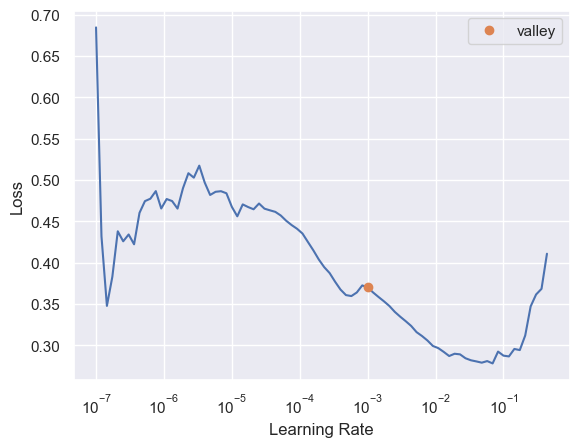

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(40, 1e-3)

epoch,train_loss,valid_loss,time
0,0.152076,0.116888,00:07
1,0.097094,0.060147,00:06
2,0.069381,0.062551,00:06
3,0.044643,0.028692,00:06
4,0.036224,0.009299,00:06
5,0.034324,0.027675,00:06
6,0.032707,0.018885,00:06
7,0.035974,0.013389,00:06
8,0.031904,0.010963,00:06
9,0.032281,0.006940,00:05


In [ ]:
preds, targs = learn.get_preds()

In [ ]:
import math


def r_mse(pred, y):
    return round(math.sqrt(((pred - y) ** 2).mean()), 6)


r_mse(preds, targs)

0.121223

In [ ]:
from fastai.interpret import Interpretation

interp = Interpretation.from_learner(learn)
interp.top_losses(k=2)

(TensorBase([0.1745, 0.1067]), TensorBase([125, 149]))

In [ ]:
interp.show_results([1, 2])

,shift_pos_12,shift_pos_11,shift_pos_10,shift_pos_9,shift_pos_8,shift_pos_7,shift_pos_6,shift_pos_5,shift_pos_4,shift_pos_3,shift_pos_2,shift_pos_1,Close,Close_pred
0,-0.104579,-0.120388,-0.174002,-0.185315,-0.118949,-0.136812,-0.077073,-0.123949,-0.136701,-0.075838,-0.076732,-0.012505,-0.030649,-0.03622
1,-0.524273,-0.485932,-0.467149,-0.477371,-0.490149,-0.328796,-0.337732,-0.393918,-0.387930,-0.294289,-0.209924,-0.243094,-0.279799,-0.17483


### Expore modelu i skalara

In [ ]:
learn.export("./models/tabular_1.pki")

In [ ]:
import joblib

In [ ]:
joblib.dump(currency_close_scaler, "./models/tabular_1_scaler.gz")

['./models/tabular_1_scaler.gz']

In [ ]:
!pip list

Package                       Version
----------------------------- ------------
annotated-types               0.5.0
anyio                         4.0.0
appnope                       0.1.3
argon2-cffi                   23.1.0
argon2-cffi-bindings          21.2.0
arrow                         1.3.0
asttokens                     2.4.1
astunparse                    1.6.3
async-lru                     2.0.4
attrs                         23.1.0
Babel                         2.13.1
backports.functools-lru-cache 1.6.5
beautifulsoup4                4.12.2
bleach                        6.1.0
blis                          0.7.10
Brotli                        1.1.0
cached-property               1.5.2
catalogue                     2.0.10
certifi                       2023.7.22
cffi                          1.16.0
charset-normalizer            3.3.2
click                         8.1.7
colorama                      0.4.6
comm                          0.1.4
confection                    0.1.3
contour

# Przykład 3

Zbudujmy swój własny model

```python
class Model(nn.Module):
    def __init__(self, input_size, hidden_size=1):
        super().__init__()
        self.lstm1 = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=False,
        )
        self.lstm2 = nn.LSTM(
            hidden_size,
            hidden_size * 2,
            num_layers=1,
            batch_first=True,
            bidirectional=False,
        )
        self.fc = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = self.fc(x)

        return x
```

... zdecydowanie dłuzsze cwiczenie

## Dodatkowe iteracje

Extending the model:

1. Add more features to the regression model,
2. Extend the LSTM to incorporate the information on the stock exchange performance,
3. Pick a ticket and use LSTM to predict the stock price based on its previous performance,
4. Write an application that exposes the model throught an REST API.

## Dodatkowe materiały

The popular alogrithms are:

- ARIMA (Autoregressive Integrated Moving Average) - implementation available in [statsmodels.org](https://www.statsmodels.org/stable/index.html),
- GARCH (Generalized autoregressive conditional heteroskedasticity) - libarry is [Arch](https://github.com/bashtage/arch).